In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,7) # Make the figures a bit bigger
import tensorflow as tf
import time
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from tensorflow.python.framework import ops
from ops import *

%matplotlib inline

Using TensorFlow backend.


In [2]:
epoch = 50 #epoch
batch_size = 64# batch_size

# image sizing
input_height = 28
input_width = 28
output_height = 28
output_width = 28

z_dim = 100       # dimension of noise-vector
c_dim = 1

# WGAN parameter
disc_iters = 2     # The number of critic iterations for one-step of generator
    
# train
learning_rate = 0.0002
beta1 = 0.5

# test
sample_num = 64  # number of generated images to be saved

# some parameters
image_dims = [input_height, input_width, c_dim]
bs = batch_size

In [3]:
def plot_gen(datas, start, end):
    for i in range(start,end):
        plt.subplot(3,(end-start)/3,i+1)

        plt.imshow(datas[i].reshape((output_height,output_width)), cmap='gray', interpolation='none')

In [4]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

num_batches = len(X_train) // batch_size

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)
(60000, 28, 28, 1)


In [5]:
#print(X_train[0])

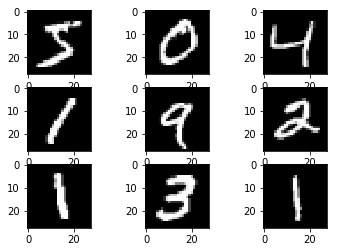

In [6]:
plot_gen(X_train,0,9)

In [7]:
X_train = X_train/255.
X_test = X_test/255.

In [8]:


""" Graph Input """
# images
inputs = tf.placeholder(tf.float32, [bs] + image_dims, name='real_images')
print(image_dims)
print(inputs.get_shape())
# noises
z = tf.placeholder(tf.float32, [bs, z_dim], name='z')
print (z.get_shape())

[28, 28, 1]
(64, 28, 28, 1)
(64, 100)


In [9]:
def discriminator( x, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : (64)4c2s-(128)4c2s_BL-FC1024_BL-FC1_S
    with tf.variable_scope("discriminator", reuse=reuse):

        net = lrelu(conv2d(x, 64, 4, 4, 2, 2, name='d_conv1'))
        net = lrelu(bn(conv2d(net, 128, 4, 4, 2, 2, name='d_conv2'), is_training=is_training, scope='d_bn2'))
        net = tf.reshape(net, [batch_size, -1])
        net = lrelu(bn(linear(net, 1024, scope='d_fc3'), is_training=is_training, scope='d_bn3'))
        out_logit = linear(net, 1, scope='d_fc4')
        out = tf.nn.sigmoid(out_logit)

        return out, out_logit, net

In [10]:
def generator( z, is_training=True, reuse=False):
    # Network Architecture is exactly same as in infoGAN (https://arxiv.org/abs/1606.03657)
    # Architecture : FC1024_BR-FC7x7x128_BR-(64)4dc2s_BR-(1)4dc2s_S
    with tf.variable_scope("generator", reuse=reuse):
        net = tf.nn.relu(bn(linear(z, 1024, scope='g_fc1'), is_training=is_training, scope='g_bn1'))
        net = tf.nn.relu(bn(linear(net, 128 * 7 * 7, scope='g_fc2'), is_training=is_training, scope='g_bn2'))
        net = tf.reshape(net, [batch_size, 7, 7, 128])
        net = tf.nn.relu(
            bn(deconv2d(net, [batch_size, 14, 14, 64], 4, 4, 2, 2, name='g_dc3'), is_training=is_training,
               scope='g_bn3'))

        out = tf.nn.sigmoid(deconv2d(net, [batch_size, 28, 28, 1], 4, 4, 2, 2, name='g_dc4'))

        return out

In [11]:
# for test
fake_images = generator(z, is_training=False, reuse=False)
z_sample = np.random.uniform(-1, 1, size=(batch_size, z_dim))
print (z_sample)
with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
    tf.global_variables_initializer().run()
    samples = sess.run(fake_images, feed_dict={z: z_sample})

[[ 0.35748535 -0.34253897 -0.64138947 ...,  0.38070384 -0.88069582
  -0.74456797]
 [-0.03136631  0.13211278  0.60147388 ..., -0.89439534 -0.60868037
  -0.30548823]
 [ 0.467427   -0.45932435 -0.48123207 ..., -0.1111757   0.7081438
   0.99301555]
 ..., 
 [ 0.48068476  0.01703604  0.6228416  ...,  0.25374992 -0.26418343
  -0.67004515]
 [ 0.93499578 -0.64997512  0.98700407 ...,  0.11567074  0.90832645
   0.25202941]
 [ 0.11353705 -0.27502838 -0.36371387 ..., -0.30475978 -0.56585333
   0.03792124]]


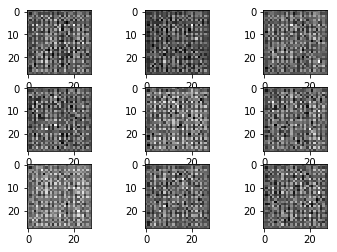

In [12]:
plot_gen(samples,0,9)

In [13]:
# output of D for real images
D_real, D_real_logits, _ = discriminator(inputs, is_training=True, reuse=False)

# output of D for fake images
G = generator(z, is_training=True, reuse=True)
D_fake, D_fake_logits, _ = discriminator(G, is_training=True, reuse=True)

# get loss for discriminator
d_loss_real = - tf.reduce_mean(D_real_logits)
d_loss_fake = tf.reduce_mean(D_fake_logits)

d_loss = d_loss_real + d_loss_fake

# get loss for generator
g_loss = - d_loss_fake

""" Summary """
d_loss_real_sum = tf.summary.scalar("d_loss_real", d_loss_real)
d_loss_fake_sum = tf.summary.scalar("d_loss_fake", d_loss_fake)
d_loss_sum = tf.summary.scalar("d_loss", d_loss)
g_loss_sum = tf.summary.scalar("g_loss", g_loss)

# final summary operations
g_sum = tf.summary.merge([d_loss_fake_sum, g_loss_sum])
d_sum = tf.summary.merge([d_loss_real_sum, d_loss_sum])

In [14]:
# divide trainable variables into a group for D and a group for G
t_vars = tf.trainable_variables()
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

In [15]:
# optimizers
with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    d_optim = tf.train.AdamOptimizer(learning_rate, beta1=beta1) \
              .minimize(d_loss, var_list=d_vars)
    g_optim = tf.train.AdamOptimizer(learning_rate*5, beta1=beta1) \
              .minimize(g_loss, var_list=g_vars)

In [ ]:
# weight clipping this is key to Wassstein GAN
clip_D = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in d_vars]

In [ ]:
result_dir = './mnist_results/' #result_dir
model_name = 'gan_model'
with tf.Session(config=tf.ConfigProto(allow_soft_placement=False)) as sess:
        # initialize all variables
    tf.global_variables_initializer().run()

    # summary writer
    writer = tf.summary.FileWriter('./logs/' + '/' + model_name, sess.graph)
    # graph inputs for visualize training results
    sample_z = np.random.uniform(-1, 1, size=(batch_size , z_dim))
    # loop for epoch
    start_time = time.time()
    
    print(start_time)
    start_epoch = 0
    start_batch_id = 0
    counter = 1
    for temp_epoch in range(start_epoch, epoch):

        # get batch data
        for idx in range(start_batch_id, num_batches):
            batch_images = X_train[idx*batch_size:(idx+1)*batch_size]
            batch_z = np.random.uniform(-1, 1, [batch_size, z_dim]).astype(np.float32)
            
            # update D network
            if (counter - 1) % disc_iters == 0:
                _, _, summary_str, dd_loss = sess.run([d_optim, clip_D, d_sum, d_loss], feed_dict={inputs: batch_images, z: batch_z})
                writer.add_summary(summary_str, counter)

            # update G network
            _, summary_str, gg_loss = sess.run([g_optim, g_sum, g_loss], feed_dict={z: batch_z})
            writer.add_summary(summary_str, counter)

            # display training status
            counter += 1
            print("Epoch: [%2d] [%4d/%4d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                  % (temp_epoch, idx, num_batches, time.time() - start_time, dd_loss, gg_loss))
            
            # save training results for every 300 steps
            if np.mod(counter, 40) == 0:
                samples = sess.run(fake_images, feed_dict={z: sample_z})
                tot_num_samples = min(sample_num, batch_size)
                manifold_h = int(np.floor(np.sqrt(tot_num_samples)))
                manifold_w = int(np.floor(np.sqrt(tot_num_samples)))
                plot_gen(samples,0,9)
                print (manifold_h)
                print (manifold_w)
                imsave(samples[:manifold_h * manifold_w, :, :, :], [manifold_h, manifold_w],
                            './' + check_folder(result_dir + '/') + '/' + model_name + '_train_{:02d}_{:04d}.png'.format(
                                temp_epoch, idx))

        # After an epoch, start_batch_id is set to zero
        # non-zero value is only for the first epoch after loading pre-trained model
        start_batch_id = 0


1511410471.8009224
Epoch: [ 0] [   0/ 937] time: 0.2928, d_loss: -0.00024628, g_loss: -0.00001556
Epoch: [ 0] [   1/ 937] time: 0.3324, d_loss: -0.00024628, g_loss: -0.00025525
Epoch: [ 0] [   2/ 937] time: 0.4112, d_loss: -0.00118761, g_loss: -0.00025060
Epoch: [ 0] [   3/ 937] time: 0.4450, d_loss: -0.00118761, g_loss: -0.00047857
Epoch: [ 0] [   4/ 937] time: 0.5145, d_loss: -0.00223161, g_loss: -0.00047379
Epoch: [ 0] [   5/ 937] time: 0.5462, d_loss: -0.00223161, g_loss: -0.00085768
Epoch: [ 0] [   6/ 937] time: 0.6079, d_loss: -0.00294754, g_loss: -0.00101122
Epoch: [ 0] [   7/ 937] time: 0.6389, d_loss: -0.00294754, g_loss: -0.00204359
Epoch: [ 0] [   8/ 937] time: 0.7042, d_loss: -0.00153821, g_loss: -0.00221066
Epoch: [ 0] [   9/ 937] time: 0.7442, d_loss: -0.00153821, g_loss: -0.00326933
Epoch: [ 0] [  10/ 937] time: 0.8108, d_loss: -0.00127455, g_loss: -0.00124598
Epoch: [ 0] [  11/ 937] time: 0.8443, d_loss: -0.00127455, g_loss: -0.00304510
Epoch: [ 0] [  12/ 937] time: 0.9

KeyboardInterrupt: 